In [1]:
import os
import json
import argparse
import sys
import shutil
from create_snippets import create_context, obtain_formatted_answers, pretty_name, find_prefix_paragraph, find_suffix_paragraph
from generate_synthetic_qa import club_speakers, find_paragraph
from tqdm import tqdm 
import pdb
import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from numerize import numerize
sns.set_theme()

/opt/conda/envs/datasets/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/datasets/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def fix_speakers(data):
    sentences = data['sentences']
    for sent in sentences:
        sent['speakerFaceId'] = str(sent['speakerFaceId'])
    data['sentences'] = sentences
    return data

In [3]:
np.random.seed(0)

In [4]:

source_path = "ProcessedTranscripts/Annotated-AMI-QA" 
files = os.listdir(source_path)
files = [f for f in files if '.json' in f]
files.sort()

In [5]:
problematic_names = ['IN1012.json', 'IN1013.json', 'IN1005.json', 'IN1007.json', 'IN1008.json']
files = [os.path.join(source_path, f) for f in files if f not in problematic_names]

In [6]:
num_train, num_dev = int(0.4*len(files)), int(0.3*len(files))
num_test = len(files) - num_train - num_dev

In [7]:
num_train, num_test, num_dev, len(files)

(64, 49, 48, 161)

In [8]:
train, dev, test, taken = [], [], [], []
train = list(np.random.choice(files, num_train, replace=False))
taken = train.copy()
test = list(np.random.choice([f for f in files if f not in taken], num_test, replace=False))
taken.extend(test)
dev = [f for f in files if f not in taken]

In [9]:
len(train), len(dev), len(test)

(64, 48, 49)

In [10]:
# add gold samples to test
gold_path = os.path.join(source_path, 'test')
gold = [os.path.join(gold_path, g) for g in os.listdir(gold_path)]
test.extend(gold)

In [11]:
len(train), len(dev), len(test)

(64, 48, 103)

In [12]:
all = train + dev + test

In [13]:
for file in test:
    if file not in gold:
        shutil.copy(file, os.path.join(source_path, 'test')) 
    

In [14]:
def process_answers(qid, answers, sentences):
    multispan = False
    speakers = set()
    offset = 0
    prev_ans = None
    answer_text = []
    for a, ans in enumerate(answers):
        ans_sentence = sentences[ans]
        ans_speaker = pretty_name(ans_sentence['speakerFaceId'])
        answer_text.append(ans_sentence['displayText'])
        speakers.add(ans_speaker)
        if a and ans - prev_ans > 1:
            multispan = True
        if not a: offset = ans - qid
        prev_ans = ans
    num_speakers = len(speakers)
    return multispan, num_speakers, offset, " ".join(answer_text)
    

    

In [38]:
def update_data(file_list):
    for file in file_list:
        data = json.load(open(file))
        data = fix_speakers(data)
        clubs = club_speakers(data)
        sentences = data['sentences']
        transcript = data['displayText']
        lookup = {}
        for sid, sentence_dict in enumerate(sentences):
            question = sentence_dict['question']
            text = sentence_dict['displayText']
            if question['possible']:
                if len(question['answerSpan']): 
                    is_impossible = False
                else: is_impossible = True
                data['sentences'][sid]['question']['meta'] = {'answerable': not is_impossible, 'multispan': False, 'multispeaker': False}
                if not is_impossible:
                    lkey = str(sorted(question['answerSpan']))
                    if lkey in lookup.keys(): lookup[lkey].append(sid)
                    else: lookup[lkey] = [sid]
                    multispan, num_speakers, offset, answer_text = process_answers(sid, sorted(question['answerSpan']), sentences)
                    # if offset < 0: print(file.split('/')[-1], sid, sorted(question['answerSpan']), len(question['combinedQuestion']))
                    # if multispan: num_multispan += 1
                    multispeaker = num_speakers > 1
                    data['sentences'][sid]['question']['meta'] = {'answerable': not is_impossible, 'multispan': multispan, 'multispeaker': multispeaker}
        # print(lookup.keys())
        for sid, sentence_dict in enumerate(sentences):
            question = sentence_dict['question']
            if question['possible']:
                if len(question['answerSpan']): 
                    is_impossible = False
                else: is_impossible = True
                if not is_impossible:
                    lkey = str(sorted(question['answerSpan']))
                    if len(question['combinedQuestion']) or len(lookup[lkey]) > 1:
                        data['sentences'][sid]['question']['combinedQuestion'] = sorted(lookup[lkey])
                    else: 
                        data['sentences'][sid]['question']['combinedQuestion'] = []
        f = open(file, 'w+')
        json.dump(data, f, indent = 4)

In [19]:
fold_train = [os.path.join(source_path + '/train', o) for o in os.listdir(os.path.join(source_path, 'train'))]
fold_dev = [os.path.join(source_path + '/dev', o) for o in os.listdir(os.path.join(source_path, 'dev'))]
fold_test = [os.path.join(source_path + '/test', o) for o in os.listdir(os.path.join(source_path, 'test'))]

In [40]:
fold_train[:10]

['ProcessedTranscripts/Annotated-AMI-QA/train/ES2003d.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/EN2003a.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/TS3003b.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/EN2001d.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/IS1002c.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/TS3003c.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/IN1001.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/ES2005a.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/IS1009d.json',
 'ProcessedTranscripts/Annotated-AMI-QA/train/ES2016c.json']

In [42]:
update_data(fold_test)

In [27]:
def perform_analysis(file_list):
    num_questions = 0
    num_answerable = 0
    num_multispan = 0 #maybe differentiate between multispan and multispeaker scenarios
    num_multi_speaker = 0
    start_distance = []
    ans_speakers = []
    meeting_length = []
    question_length = []
    answer_length = []
    questions_per_meeting = []

    for file in file_list:
        this_meeting = 0
        data = json.load(open(file))
        data = fix_speakers(data)
        clubs = club_speakers(data)
        sentences = data['sentences']
        transcript = data['displayText']
        meeting_length.append(len(word_tokenize(transcript)))
        for sid, sentence_dict in enumerate(sentences):
            question = sentence_dict['question']
            text = sentence_dict['displayText']
            if question['possible']:
                num_questions += 1
                this_meeting += 1
                question_length.append(len(word_tokenize(text)))
                if len(question['answerSpan']): 
                    is_impossible = False
                    num_answerable += 1
                else: is_impossible = True
                if not is_impossible:
                    multispan, num_speakers, offset, answer_text = process_answers(sid, sorted(question['answerSpan']), sentences)
                    # if offset < 0: print(file.split('/')[-1], sid, sorted(question['answerSpan']), len(question['combinedQuestion']))
                    if multispan: num_multispan += 1
                    if num_speakers > 1: num_multi_speaker += 1
                    ans_speakers.append(num_speakers)
                    start_distance.append(offset)
                    answer_length.append(len(word_tokenize(answer_text)))
                # else: answer_length.append(0)
        questions_per_meeting.append(this_meeting)
    stats = {'numQuestions': num_questions, 'numAnswerable': num_answerable, 'numMultiSpan': num_multispan, 'numMultiSpeaker': num_multi_speaker}
    stats['numUnAnswerable'] = num_questions - num_answerable
    stats['% Answerable'] = round(100*num_answerable/num_questions, 2)
    stats['Rel % MultiSpan'] = round(100*num_multispan/num_answerable, 2)
    stats['Rel % MultiSpeaker'] = round(100*num_multi_speaker/num_answerable, 2)
    stats['Avg. Q per Meeting'] = round(np.mean(questions_per_meeting), 2)
    return meeting_length, question_length, answer_length, ans_speakers, start_distance, stats 

In [21]:
all_meeting_length, all_question_length, all_answer_length, all_ans_speakers, all_start_distance, all_stats  = perform_analysis(all)

In [22]:
print(all_stats)

{'numQuestions': 7735, 'numAnswerable': 5394, 'numMultiSpan': 1995, 'numMultiSpeaker': 2591, '% Answerable': 69.73, 'Rel % MultiSpan': 36.99, 'Rel % MultiSpeaker': 48.03, 'Avg. Q per Meeting': 46.6}


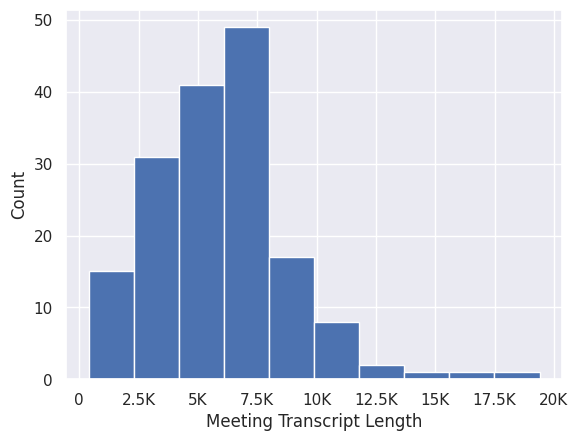

In [83]:
fig, ax = plt.subplots()
plt.hist(all_meeting_length, bins=10)
plt.ylabel('Count')
plt.xlabel('Meeting Transcript Length')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
plt.savefig('paper/figures/meeting_len_hist.pdf', bbox_inches='tight')
plt.show()

In [84]:
all_question_length[:10]

[5, 7, 4, 12, 7, 12, 12, 9, 10, 7]

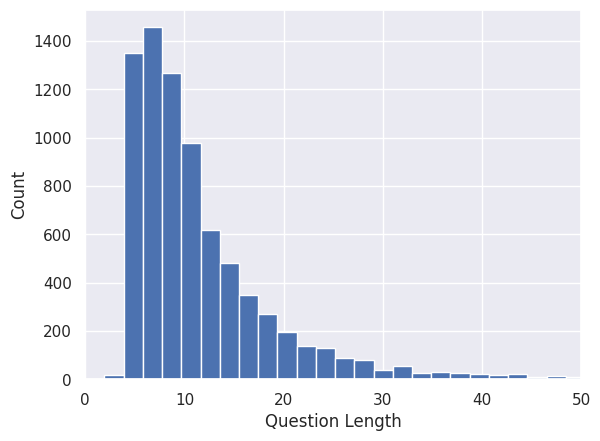

In [76]:
fig, ax = plt.subplots()
plt.hist(all_question_length, bins=80)
plt.ylabel('Count')
plt.xlim([0,50])
plt.xlabel('Question Length')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
plt.savefig('paper/figures/question_len_hist.pdf', bbox_inches='tight')
plt.show()

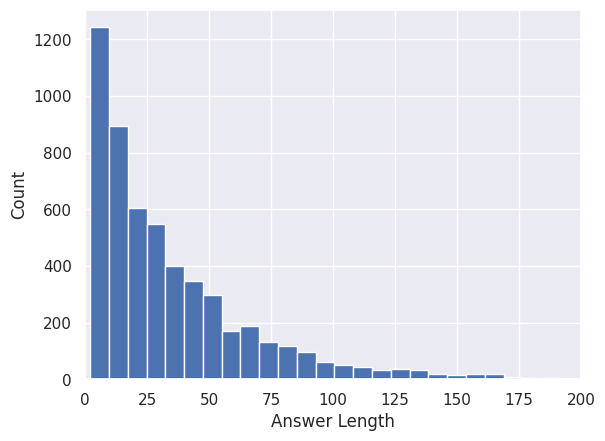

In [107]:
fig, ax = plt.subplots()
plt.hist(all_answer_length, bins=40)
plt.ylabel('Count')
plt.xlim([0,200])
plt.xlabel('Answer Length')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
plt.savefig('paper/figures/answer_len_hist.pdf', bbox_inches='tight')
plt.show()

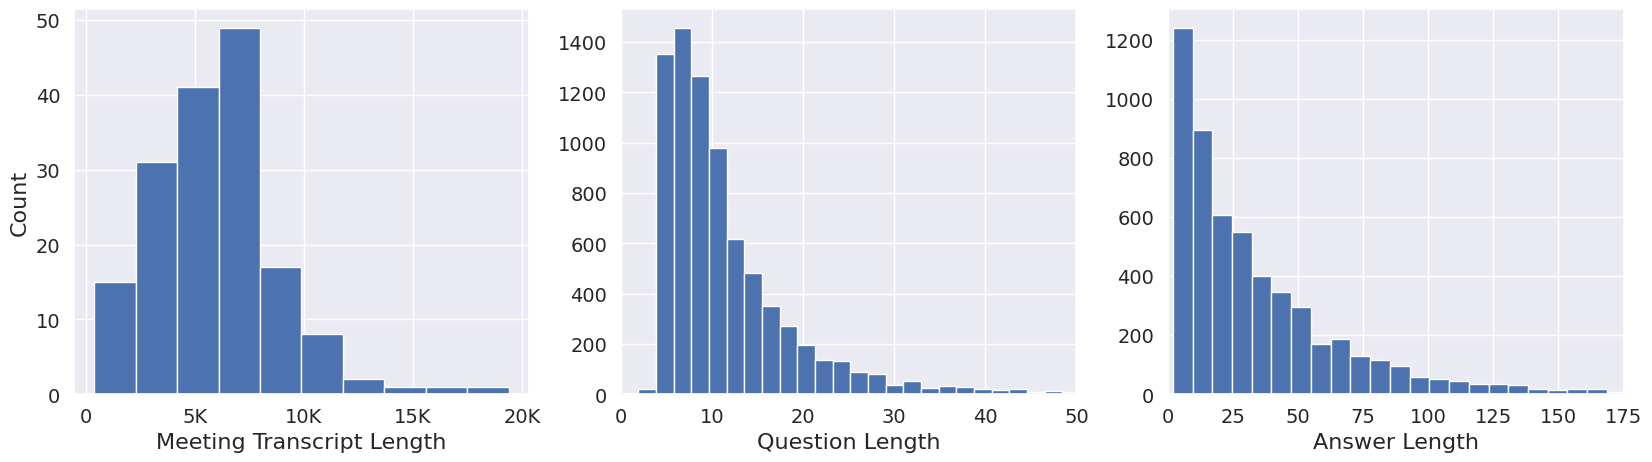

In [45]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].hist(all_meeting_length, bins=10)
ax[0].set_ylabel('Count', fontsize=16)
ax[0].set_xlabel('Meeting Transcript Length', fontsize=16)
ax[0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].hist(all_question_length, bins=80)
# ax[1].set_ylabel('Count')
ax[1].set_xlim([0,50])
ax[1].set_xlabel('Question Length', fontsize=16)
ax[1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[2].hist(all_answer_length, bins=40)
# plt.ylabel('Count')
ax[2].set_xlim([0,175])
ax[2].set_xlabel('Answer Length', fontsize=16)
ax[2].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
ax[2].tick_params(axis='both', which='major', labelsize=14)
plt.savefig('paper/figures/all_hist.pdf', bbox_inches='tight')
plt.show()

In [16]:
#compute averages and maximum
print("Average..")
print(np.mean(all_meeting_length), np.mean(all_question_length), np.mean(all_answer_length))
print("Max..")
print(max(all_meeting_length), max(all_question_length), max(all_answer_length))

Average..
5872.692771084337 11.573238526179702 34.68186874304783
Max..
19394 155 305


In [28]:
_, _, _, _, _, train_stats = perform_analysis(train)
_, _, _, _, _, dev_stats = perform_analysis(dev)
_, _, _, _, _, test_stats = perform_analysis(test)

In [29]:
print(train_stats)
print(dev_stats)
print(test_stats)

{'numQuestions': 3007, 'numAnswerable': 2050, 'numMultiSpan': 784, 'numMultiSpeaker': 1014, 'numUnAnswerable': 957, '% Answerable': 68.17, 'Rel % MultiSpan': 38.24, 'Rel % MultiSpeaker': 49.46, 'Avg. Q per Meeting': 46.98}
{'numQuestions': 2252, 'numAnswerable': 1631, 'numMultiSpan': 549, 'numMultiSpeaker': 738, 'numUnAnswerable': 621, '% Answerable': 72.42, 'Rel % MultiSpan': 33.66, 'Rel % MultiSpeaker': 45.25, 'Avg. Q per Meeting': 46.92}
{'numQuestions': 2476, 'numAnswerable': 1713, 'numMultiSpan': 662, 'numMultiSpeaker': 839, 'numUnAnswerable': 763, '% Answerable': 69.18, 'Rel % MultiSpan': 38.65, 'Rel % MultiSpeaker': 48.98, 'Avg. Q per Meeting': 45.85}
